# Exercise Sheet 4

## Part 1: Gaussian Process Regression

### Library Loading Block

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thursday October 3, 2024

@authors: Elena Raponi, Kirill Antonov, Ivan Olarte-Rodriguez

"""

# Import the Libraries

# Typical Libraries for Numerical Processing
import numpy as np
from matplotlib import pyplot as plt

# Scikit Learn Libraries (For handling basic Regression Processes)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern,RBF, ConstantKernel as C
from typing import Callable
import pyDOE2

In the following block there are listed four different functions. Run this block in order to load the functions into the main module. These functions are then going to be switched to perform different approximations with the regressors.

In [2]:
def f(X:np.ndarray):
    # 1D example function to illustrate Gaussian process
    x = X.copy()
    return x * np.cos(x) + 10

def Ackley(x1:np.ndarray, x2:np.ndarray):
    # Usually evaluated on [-5,5]^2
    # Global minimum at (0, 0) where f(x1, x2) = 0
    return -20*np.exp(-0.2*np.sqrt(0.5*(x1**2+x2**2))) - np.exp(0.5*(np.cos(2*np.pi*x1)+np.cos(2*np.pi*x2))) + 20 + np.e

def Rosenbrock(x1:np.ndarray, x2:np.ndarray): 
    # Usually evaluated on [-2,2]^2
    # Global minimum at (a,a^2) where f(x1,x2)=0
    a = 1
    b = 100     
    return (a-x1)**2 + b*(x2 - x1**2)**2

def Quadratic(x1:np.ndarray, x2:np.ndarray):
    # Can be evaluated on any search domain
    # Global minimum at (0,0) where f(x1,x2)=0
    return x1**2 + x2**2

Run the following block to plot the implementation of the interpolation

In [3]:
# define our known points and their measurements
# We start with a 1D simple example
# Sampling locations
xi = np.atleast_2d([-3., -1, 1.5, 2.5, 3]).T

# Sample observations
fi = f(xi).ravel()

# Some length scale
L= 1.0

The following block is a helper block to generate plotting functions. These are meant to plot the function, the prediction and the 95% confidence interval based on the mean squared error.

In [4]:
def plot_results_2d(X_obs, y_obs, x, y_pred, sigma):
    plt.figure()
    plt.plot(x, f(x), 'r:', label='$f(x) = x\ cos(x) + 10$')
    plt.plot(X_obs, y_obs, 'r.', markersize=10, label='Observations')
    plt.plot(x, y_pred, 'k-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.3, fc='k', label='95% confidence interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(0, 25)
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.show()
    
def plot_doe(x, lb = 0.0, ub = 1.0):
    num_samp = np.size(x,0)
    num_sampf = float(num_samp)
    fig = plt.figure()
    ax = fig.gca()
    ax.scatter(x[:,0],x[:,1])
    # --- boundaries of the design space
    ax.plot([0,0,1,1,0],[0,1,1,0,0], color=[0.5,0.5,0.5], linestyle='--', linewidth = 0.5)
    # --- grid lines  
    for i in range(num_samp):
        tmp = lb + (ub-lb)*i/num_sampf
        ax.plot([lb,ub],[tmp,tmp],color=[0.5,0.5,0.5], linestyle=':')
        ax.plot([tmp,tmp],[lb,ub],color=[0.5,0.5,0.5], linestyle=':')
        
    ax.set_xlim(lb,ub)
    ax.set_ylim(lb,ub)
    # -- labels
    ax.set_xlabel('x1', labelpad=8)
    ax.set_ylabel('x2', labelpad=8)
    plt.title('Optimal LH Samples', fontsize = 12)
    plt.axis('square')
    
def plot_results_3d(x1, x2, y_pred, x_samp=None, y_samp=None, lb=0.0, ub=1.0, title = '3D surface plot'):
    
    plt.figure(figsize=(15,10))

    fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(x1, x2, y_pred, cmap='coolwarm', alpha = 0.6)
    if x_samp is not None:
        ax.scatter(x_samp[:,0], x_samp[:,1], y_samp, c='r', marker='x')
    ax.set_xlim(lb,ub)
    ax.set_ylim(lb,ub)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Obj. Function')
    ax.set_title(title)

### Exercise 1: Gaussian Process Regression
Fit the gaussian process regression (GPR) model using Scikit Learn's class `GaussianProcessRegressor`. Sample points and kernel definition are given. Define all the input parameters required by `plot_results_2d`.

In the following setting, the final model is obtained by using numerical optimization techniques to maximize the likelihood of the observed data, given our GPR model. Set the number of restarts for the optimizer to 10. Furthermore, in the following block you may find the definition of two kernels from `scikit-learn`, namely a composite kernel comprising a RBF and a constant kernel and a Matérn kernel. In addition to this, try changing the length scale.

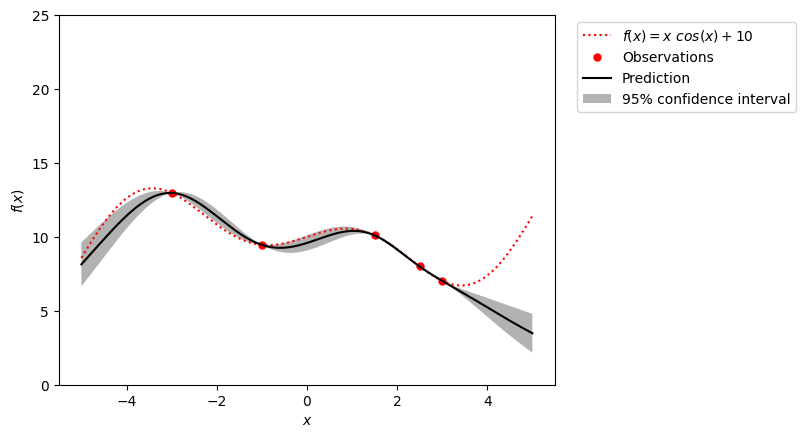

In [5]:
if __name__ == '__main__':
    
    # We start with a 1D simple example
    # Sampling locations
    X:np.ndarray = xi.copy()

    # Sample observations
    y = fi.copy()

    # Mesh the input space for evaluations of the real function, the prediction and confidence interval
    x = np.atleast_2d(np.linspace(-5, 5, 1000)).T

    # Initiate a Gaussian Process model
    # RBF stands for Radial-basis function kernel (i.e. squared-exponential kernel
    # Other available kernels include: C (for constant), WhiteKernel (for white noise), 
    #                                  Matern, RationalQuadratic, ExpSineSquared (for a periodic kernel)
    # See https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes
    # for detailed documentation of all available kernels
    
    ##### TODO: In this part switch between the following defined kernels. Evaluate the results by switching each of them
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=L)
    kernel = Matern(length_scale=L/1/3,nu=2.5)

    #####--------------- END OF SWITCH -----------------------
    
    ##### TODO: Enter your code here:
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    # Fit GPR model to observations (--> Maximum Likelihood Estimation)
    gp.fit(X, y)

    # Make the prediction on the meshed x-axis (ask for standard deviation as well)
    y_pred, sigma = gp.predict(x, return_std=True)
    
    ##### --------------- END OF CODE INPUT -----------------------

    
    plot_results_2d(X,y,x,y_pred,sigma)

### Exercise #2: Two-dimensional Gaussian Process Regression
Bring all your knowledge together and implement the whole process, from DoE to GPR regression, in this 2D example, i.e. we work with 2 variables and fit a response surface in a 3-dimensional space.

c:\Users\iolar\anaconda3\envs\test_bo_torch\lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


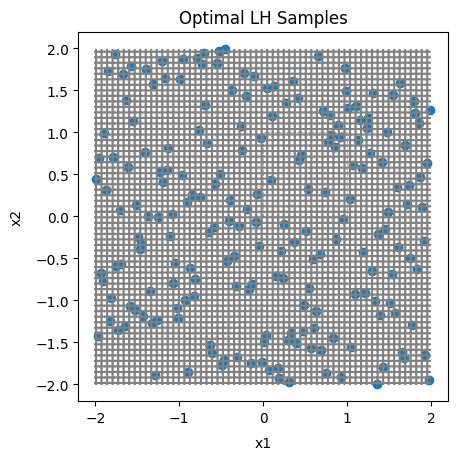

<Figure size 1500x1000 with 0 Axes>

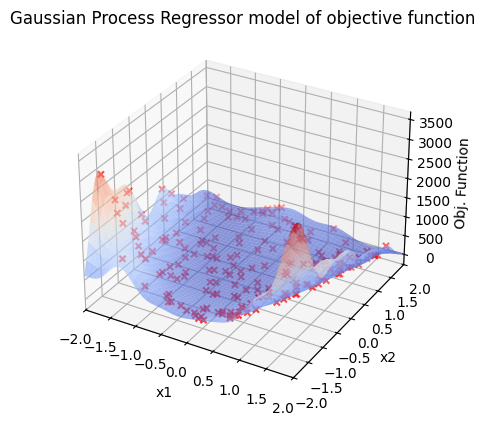

<Figure size 1500x1000 with 0 Axes>

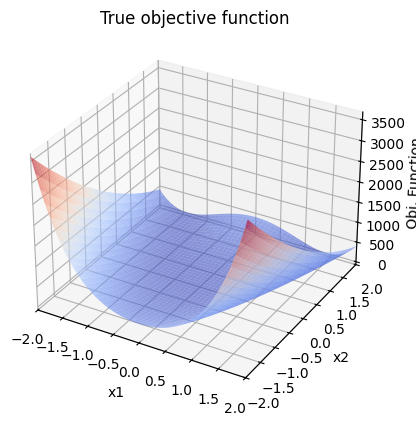

<Figure size 1500x1000 with 0 Axes>

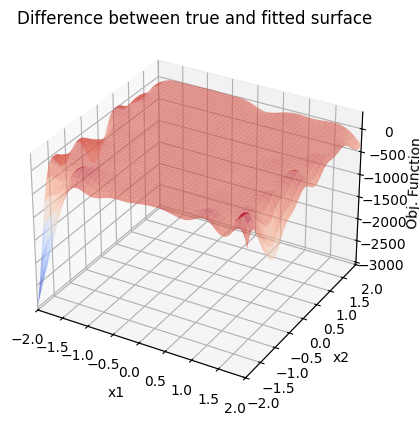

In [6]:
if __name__ == '__main__':
    
    # Set parameters
    g = Rosenbrock # options are Quadratic, Ackley, Rosenbrock
    num_dv = 2
    num_samp = 200  # Usually 10*[number of design variables] is a good rule of thumb
    lb = -2
    ub = 2
    
    ##### TODO: Enter your code here:
    
    # Create samples using Optimal Latin Hypercube approach
    x_samp = pyDOE2.lhs(num_dv, num_samp, criterion = 'centermaximin', iterations = 50000)
    x_samp = lb + (ub-lb)*x_samp  # We have to map the generated samples back to our design space
    plot_doe(x_samp, lb, ub)
    
    # Calculate objective function values
    y_samp = g(x_samp[:,0], x_samp[:,1])

    #Initiate Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    
    # Fit GPR model to observations (--> Maximum Likelihood Estimation)
    gp.fit(x_samp, y_samp)
    
    #Predict values on a meshed input space
    x1_obs, x2_obs = np.meshgrid(np.linspace(lb,ub,100), np.linspace(lb,ub,100))
    x_obs = np.array([np.reshape(x1_obs, (1,np.prod(x1_obs.shape)))[0], \
                      np.reshape(x2_obs, (1,np.prod(x2_obs.shape)))[0]]).T
    
    y_pred = gp.predict(x_obs)
    y_pred = np.reshape(y_pred, (100,100))
    
    ##### --------------- END OF CODE INPUT -----------------------
    
    #Visualize results
    plot_results_3d(x1_obs, x2_obs, y_pred, x_samp, y_samp, lb=lb, ub=ub,\
                   title='Gaussian Process Regressor model of objective function')
    
    #Also plot original function for comparison
    plot_results_3d(x1_obs, x2_obs, g(x1_obs,x2_obs), lb=lb, ub=ub,\
                   title='True objective function')
    
    #Finally get the difference between original and fitted surface
    plot_results_3d(x1_obs, x2_obs, y_pred - g(x1_obs,x2_obs), lb=lb, ub=ub,\
                   title='Difference between true and fitted surface')

### Exercise #3: Implement a Kernel Extension and predict functions
In the following blocks you're encouraged to generate your own tailormade Kernel and Predict functions. In the next block, you're encouraged to write a Matern Kernel yourself. For this, we will extend the abstract kernel definition found in `scikit-learn` (https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Kernel.html#sklearn.gaussian_process.kernels.Kernel). In this setting a fixed member variable is needed, namely a `length scale` definition. On the other hand, the Matern Kernel requires parameters `nu` and `alpha_0`.

In the following block implement the `__call__` function. The steps are commented as a hint.

Specifically, the Matern Kernel is defined as:

$$K(x,x^{\prime}|\alpha_{0},\nu) = \alpha_{0} \frac{2^{1-\nu}}{\Gamma(\nu)} \left(  \sqrt{2 \nu} \ d(x,x^{\prime})   \right)^{\nu} J_{(\nu)} \left(  \sqrt{2 \nu} \ d(x,x^{\prime})    \right)$$ 

Where $d(x,x^{\prime}) $ is a distance metric between two points in the parameter space. Given that the space is finite dimensional, then this distance is normally the Euclidean distance (or __2-norm__)factored by a length scale $L$ as:

$$ d(x,x^{\prime})  = \frac{||x - x^{\prime} ||_{2}}{L}$$

On the other hand $\Gamma(\nu)$ represents the Gamma function evaluated at $\nu$. This function is evaluated via `scipy.special.gamma`. $J_{(\nu)}$ is the modified Bessel function of the second kind parameterized by $\nu$. This is evaluated via the function `scipy.special.kv`.

In [7]:

from sklearn.gaussian_process.kernels import Kernel
from scipy.special import kv, gamma

class CustomMaternKernel(Kernel):
    def __init__(self, length_scale:float, nu:float=1.5, alpha_0:float = 1.0):
        ''' 
        This initialization requires the definition of and length scale (as default from Kernel framework)
        as well as the parameters of the Matern kernel (nu and alpha_0). In this case (to simplify the implementation)
        this kernel should be isotropic, meaning that the length scale is a scalar value 
        '''
        self.__length_scale:float = length_scale
        self.__nu:float = nu
        self.__alpha_0:float = alpha_0

        
    def __call__(self, x1:np.ndarray, x2:np.ndarray=None)->np.ndarray:
        ''' 
        The call function Requires x1 and x2 to each represent points in the parametric space. 
        The size of x1 should be (n1 x d) and x2 should be (n2 x d), where d stands for the dimensionality of the problem. 

        The output of this call function must be a n1 x n2 matrix. The matrix has the computation of kernel(x1[ii,:],x2[jj,:]), where ii in range(x1.shape[0]) 
        and jj in range(x2.shape[0])
        '''
        if x2 is None:
            x2 = x1.copy()

    
        matrix = np.zeros((x1.shape[0],x2.shape[0]))

        ##### TODO: Enter your code here:
        for ii in range(matrix.shape[0]):
            for jj in range(matrix.shape[1]):

                # =========Compute the variable r: ==========================
                # r is the Euclidean distance between x1 and x2,
                # after we normalize each dimension by the length scale
                r = np.linalg.norm(np.divide(x1[ii,:]-x2[jj,:],self.__length_scale),ord=2)


                # ========= Adjust the case when r=0: ==========================
                # When r is 0 (which causes tmp to be 0),
                # the code below returns nan because tmp**nu is 0 but kv(nu,tmp) is infinite.
                # We fix this by adding a small amount to r in this situation.
                # We could have also fixed this by simply returning alpha0,
                # which is the correct covariance when r/0.
                if r==0.:
                    r += np.finfo(float).eps

                # ========= Compute the formula for the Matern Kernel: ==========================
                tmp =   np.sqrt(2*self.nu)*r
                matrix[ii,jj] = self.__alpha_0 * self.c * tmp**self.__nu *(self.__nu, tmp)

        ##### --------------- END OF CODE INPUT -----------------------

        return matrix 

    
        
    ### These are methods required by the implementation
    def diag(self, X:np.ndarray):
        if len(X.shape)==1:
            np.expand_dims(X,axis=1)
            
        r = np.zeros(X.shape[0]) + np.finfo(float).eps
        
        tmp =   np.sqrt(2*self.__nu)*r
        return self.__alpha_0 * self.c * tmp**self.__nu * kv(self.__nu, tmp)

    def is_stationary(self):
        return True
    
    @property
    def alpha_0(self)->float:
        return self.__alpha_0
    
    @property
    def nu(self)->float:
        return self.__nu
    
    @property
    def length_scale(self)->float:
        return self.__length_scale
    
    @alpha_0.setter
    def alpha_0(self,new_alpha_0:float)->None:
        self.__alpha_0 = new_alpha_0

    @nu.setter
    def nu(self,new_nu:float)->None:
        self.__nu = new_nu

    @length_scale.setter
    def length_scale(self,new_length_scale:float)->None:
        self.__length_scale = new_length_scale
    
    @property
    def c(self)->float:
        return   2**(1-self.__nu) / gamma(self.__nu)
    

# Call an instance of your customized kernel
kernel = CustomMaternKernel(length_scale=1/L,alpha_0=0.5,nu=1.5)

# Print a computation
X = np.array([[1, 2], [3, 4]])
X2 = np.array([[2, 3], [4, 5]]) kv
print(kernel(X,X2))

[[0.14891038 0.00268644]
 [0.14891038 0.14891038]]


Now run the following block to test your customized Kernel.

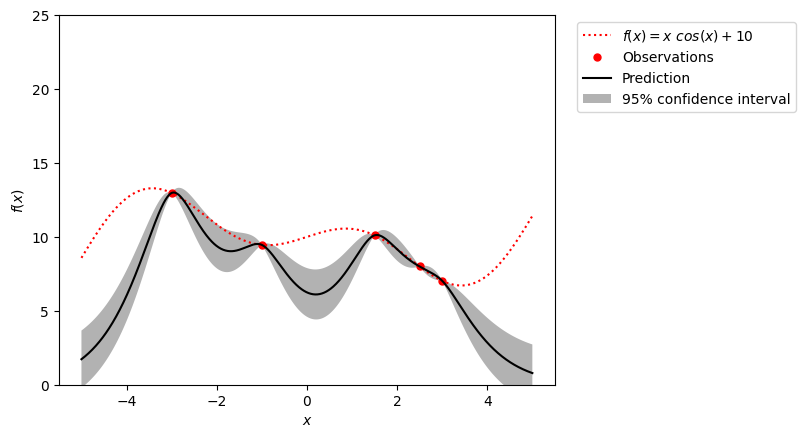

In [8]:
if __name__ == '__main__':
    
    # We start with a 1D simple example
    # Sampling locations
    X:np.ndarray = xi.copy().reshape((-1, 1))


    # Sample observations
    y = fi.copy().reshape((-1, 1))
    

    # Mesh the input space for evaluations of the real function, the prediction and confidence interval
    x = np.atleast_2d(np.linspace(-5, 5, 1000)).reshape((-1, 1))

    # Initiate a Gaussian Process model
    kernel = CustomMaternKernel(length_scale=1/L,nu=1.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    # Fit GPR model to observations (--> Maximum Likelihood Estimation)
    gp.fit(X, y)

    # Make the prediction on the meshed x-axis (ask for standard deviation as well)
    y_pred, sigma = gp.predict(x, return_std=True)
    
    
    plot_results_2d(X,y,x.reshape((-1,1)),y_pred.reshape((-1,1)),sigma.reshape((-1,1)))

Now it's turn to call a customized `fit_predict` function. Write a function that calculates the mean and variance of the 
posterior distribution at a point test_x. Your function should 
return the result as a list, where the first entry  is the posterior mean
and the second is the posterior variance.  You may find that because of 
numerical imprecision, the posterior variance can be slightly negative.

The mean and variance of the posterior distribution are defined as:
\begin{align}
f(x) &\mid f(x_{1:n}) \sim \mathrm{Normal}(\mu_n(x),\sigma^2_n(x))\\
\mu_n(x) &= \Sigma_0(x,x_{1:n}) \Sigma_0(x_{1:n},x_{1:n})^{-1} (f(x_{1:n})-\mu_0(x_{1:n})) + \mu_0(x) \\
\sigma^2_n(x) &= \Sigma_0(x,x) - \Sigma_0(x,x_{1:n}) \Sigma_0(x_{1:n},x_{1:n})^{-1} \Sigma_0(x_{1:n},x)
\end{align}


For the solution we suggest two linear algebra functions from numpy:
- numpy.linalg.inv: https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html
- numpy.matmul: https://numpy.org/doc/stable/reference/generated/numpy.matmul.html

*Hint 1*: The formula in the BayesOpt tutorial has the expression,
$\Sigma_0(x_{1:n},x)$
which is a short way of writing the column vector,
$[\Sigma_0(x_1,x), \ldots, \Sigma_0(x_n,x)]^T$.

Suppose we have python code where:
* $\Sigma_0$ is computed by the function `kernel`
* $x_{1:n}$ is stored in the list `train_x`
* We have another point `x`

So then the row vector $\Sigma_0(x_{1:n},x)$ we want to construct is:

    [kernel(train_x[0],x),..., kernel(train_x[n-1],x))]

A quick way to construct this row vector as a list is 

    [kernel(y,x) for y in train_x]

*Hint 2:* You can convert a list of numbers to a numpy array. This allows for matrix multiplication, taking the transpose, and adding a subtracting scalars.

In [9]:
# This defines a mean function that evaluates to 0 for all inputs 
mean0 = lambda x : 0.0
kern = CustomMaternKernel(length_scale=1/L,alpha_0=0.5,nu=1.5)


def fit_predict(test_x, train_x, train_y, mean = mean0, kernel=kern):
    # Inputs:
    # test_x is a point in the x space
    # train_x is an array of points
    # train_y is an array equal in length to train_x, giving the value of our observation at each point
    # mean and kernel are two functions
    # mean should take one point as input, mean(x)
    # kernel should take two points as input, kernel(x,xprime)
    
    ##### TODO:  Enter your code here:
    
    # An array with the mean
    mu_v = np.vectorize(mean) 
    mu0 = mu_v(train_x)

    if not isinstance(test_x,np.ndarray):
        test_x = np.array([test_x]).reshape((-1,1))

    # K is the matrix kernel(train_x,train_x)
    K = kernel(train_x)
    Kinv = np.linalg.inv(K)

    # A is the vector kernel(test_x,train_x), which is 1 by n
    # B is its product with K^-1
    
    A = kernel(test_x,train_x)
    B = np.matmul(A,Kinv)

    pred_mean = np.matmul(B,train_y-mu0) + mu_v(test_x).reshape((-1,1))
    pred_var = kernel(test_x,test_x) - np.matmul(B,np.transpose(A))
    
    ##### --------------- END OF CODE INPUT -----------------------
    
    return (pred_mean, pred_var)
    
    
# Here are some examples of what your function should return.
# The posterior variance is very low for the first example because we are asking
# for a prediction for a point that is in the training data. 
print(fit_predict(0.9, X.reshape((-1, 1)), y.reshape((-1, 1))))
print(fit_predict(2, X.reshape((-1, 1)), y.reshape((-1, 1))))
print(fit_predict(-2, X.reshape((-1, 1)), y.reshape((-1, 1))))

(array([[7.78400052]]), array([[0.22498045]]))
(array([[9.16182795]]), array([[0.07726322]]))
(array([[9.38179575]]), array([[0.29488927]]))


## Part 2: Acquisition Functions
In this section of the exercise you will now work with the acquisition functions. In the framework of Bayesian Optimization, you first need to build a surrogate model through a Gaussian Process Regression. With the information of the regressor, then you need to decide the next point of the decision space to pick. This decision process is evaluated through an acquisition function which points the "next most interesting point" according to some metric embedded into the acquistion function.

### Preliminaries:

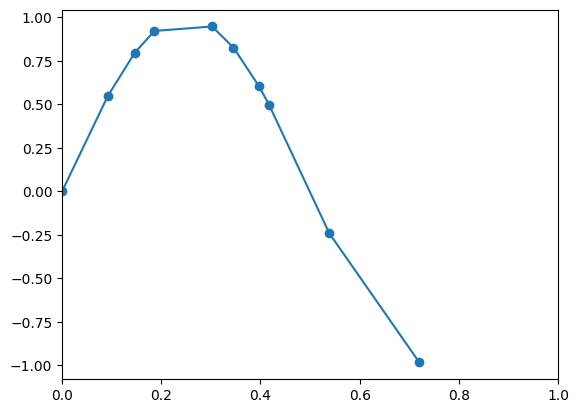

In [10]:
import os.path
import math
# Read in data from a file.  Download this from the BrightSpace  before you start.  
# If you forget to do this, the cell will generate the data for you, but small
# differences in random number generators might lead to different training data,
# which may make the lab harder to do.
filename = 'lab1_data.csv'

# If data doesn't exist, generate it
if not os.path.exists(filename):
    np.random.seed(1)
    train_x = np.sort(np.random.rand(10)) # 10 points, uniformly distributed between 0 and 1
    train_y = [math.sin(x * (2 * math.pi)) + 0.0 * np.random.randn() for x in train_x]
    data = np.transpose([train_x,train_y])
    np.savetxt(filename,data)

# Read in data from a file.  
data = np.loadtxt(filename)
train_x = data[:,0] # First column of the data
train_y = data[:,1] # Second column of the data
plt.xlim(0,1)
plt.plot(train_x, train_y,'o-')

In [11]:
def plot_prediction(train_x, train_y, gpr:GaussianProcessRegressor):
    m = []
    lb = []
    ub = []

    train_x = train_x.reshape((-1,1))
    train_y = train_y.reshape((-1,1))

    # Fit the GPR
    gpr.fit(train_x,train_y)

    x = np.linspace(0,1,100)
    for test_x in x:
        pred_mean, pred_std = gpr.predict(np.array([test_x]).reshape(-1,1),return_std=True)
        m.append(pred_mean)
    
        # Calculate the posterior standard deviation
        if pred_std<0:
            print('Posterior standard deviation is negative ({:e}) at x={}, rounding up to 0'.format(pred_std, test_x))
            pred_std = 0
    
        s = pred_std.copy() 
        
        lb.append(pred_mean-1.96*s)
        ub.append(pred_mean+1.96*s)
    
    m = np.array(m).ravel()
    lb = np.array(lb).ravel()
    ub = np.array(ub).ravel()

    _, ax = plt.subplots(figsize=(6.5, 4))
    ax.plot(train_x,train_y,'ko')
    ax.plot(x,m.ravel(),'k',linewidth=0.5)
    ax.fill_between(x,lb,ub)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

### Exercise 4: The Expected Improvement Function
The Expected Improvement is the most used acquisition function in most Bayesian Optimization frameworks. The main advantage of this function is that it has embedded both exploration and exploitation balance and can be computed in a closed form (without expensive numerical computations).

Write a function that calculates the expected improvement given the posterior mean (m), posterior variance (v),
and the value of the best point observed (best_y), for settings where we are maximizing.
You can use either of these two equivalent formulas:

$$\mathrm{EI}_n(x) = \sigma_n(x) \varphi\left(\frac{\Delta_n(x)}{\sigma_n(x)}\right) + \Delta_n \Phi\left(\frac{\Delta_n(x)}{\sigma_n(x)}\right)$$


$$\mathrm{EI}_n(x) = [\Delta_n(x)]^+ + \sigma_n(x) \varphi\left(\frac{\Delta_n(x)}{\sigma_n(x)}\right) - |\Delta_n|\Phi\left(\frac{-|\Delta_n(x)|}{\sigma_n(x)}\right)$$
where
- $\mu_n(x)$ is the posterior mean at $x$
- $\sigma_n(x)$ is the posterior standard deviation at $x$
- $\varphi$ is the density of the standard normal distribution (i.e., normal distribution with mean 0 and variance 1)
- $\Phi$ is the cdf of the standard normal distribution
- $\Delta_n(x)$ is $\mu_n(x) - f^*_n$ when we are maximizing and $f^*_n - \mu_n(x)$ when we are minimizing, where $f^*_n$ is the value of the best point observed so far


Your code may need to handle very small variances as a special case to avoid dividing by 0.
The EI for a variance of 0 is max(0,m-best_y).  You may also need to handle small negative variances 
--- treat them as 0.

You can use `scipy.stats.norm.pdf` and `scipy.stats.norm.cdf`

In [12]:
from scipy.stats import norm


def EI(m:float,v:float,best_y:float, minimization:bool = False):
    
    '''
    This is a base Expected Improvement function. The inputs of this function are:
    - m: The posterior mean
    - v: The posterior variance
    - best_y: The sampled best value of the objective
    - minimization: A boolean handle to determine if the objective is minimized or maximized
    '''
       
        
    ##### TODO: Enter your code here:

    if v <= 0:
        ret = max(0,m-best_y)
    else:   
        if minimization:
            delta = best_y - m
        else:
            delta =  m - best_y
            
        s = np.sqrt(v)
        z = delta / s
        ret = max(0,delta)
        ret += s * norm.pdf(z, loc=0) 
        ret -= abs(delta)*norm.cdf(-1*abs(z))
    
    return ret
    
    ##### --------------- END OF CODE INPUT -----------------------



# Test your code!!!
print(EI(1,1e-100,0))
print(EI(2,1,0))
print(EI(0,2,2))
print(EI(0,10,2))


1.0
2.0084907026168297
0.05025454166001228
0.5057938380690186


### Other Acquistion Functions
In the following block you will find the definition of other acquisition functions. Notice the inputs are mostly the same from before except for the last parameters.

In [13]:
def ucb(m:float,v:float,best_y:float, psi=1.96):
    """The upper confidence acquisition function."""
    if v <= 0:
        return max(0,m-best_y)

    return m + psi * np.sqrt(v)

def lcb(m:float,v:float,best_y:float, psi=1.96):
    """The lower confidence acquisition function."""
    if v <= 0:
        return max(0,m-best_y)
    
    return m - psi * np.sqrt(v)

def poi(m:float,v:float,best_y:float, psi=0.):
    """Return the probability of improvement.
    
    Arguments
    psi   -- A parameter that controls exploration.
    """
    if v <= 0:
        return max(0,m-best_y)
    
    return norm.cdf((m - best_y - psi) / np.sqrt(v))

### Exercise 5: Plotting an acquisition function
Define a function `plot_acq` which uses the function defined above to compute it. In order to compute the variance, first use `GPR.fit(train_x,train_y)` to fit the model and then `GPR.predict(test_x, return_std=True)` to get the prediction of the mean and the prediction of the variance, respectively.


[ 7.18638110e-04  5.48174911e-01  7.96868738e-01  9.20870496e-01
  9.46425589e-01  8.25095140e-01  6.04094477e-01  4.98065220e-01
 -2.41481975e-01 -9.82667252e-01]
0.9464255890012647


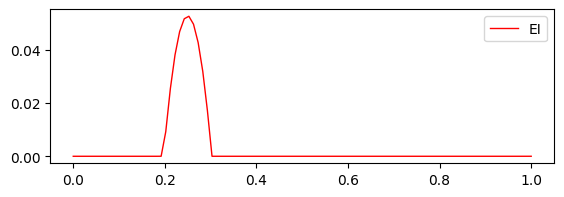

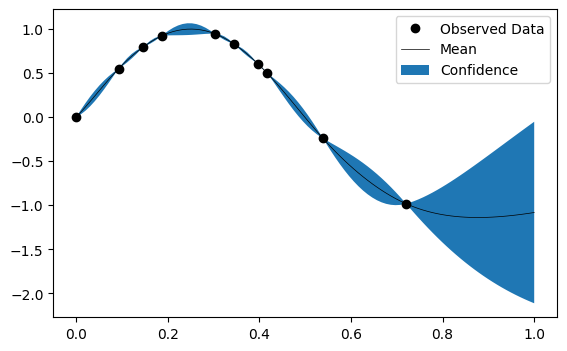

In [14]:
kernel = Matern(length_scale=0.8,
               length_scale_bounds=(1e-05,9e-01),
               nu=1.5)
# kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
sampleGPR = GaussianProcessRegressor(kernel=kernel,
                                    n_restarts_optimizer=10)

sampleGPR.fit(X=train_x.reshape((-1,1)),
                             y=train_y.reshape((-1,1)))

# Using any acquistion function, we plot the posterior
def plot_acq(train_x:np.ndarray,
            train_y:np.ndarray,
            best_y:float, 
            acq_fun:Callable=EI,
            GPR:GaussianProcessRegressor=sampleGPR,
            acq_fun_name:str = "EI"):
    
    if train_x.shape[0] == train_x.size:
        train_x = train_x.reshape((-1,1))

    if train_y.shape[0] == train_y.size:
        train_y = train_y.reshape((-1,1))

    best_y:np.ndarray = np.array([best_y]).reshape((-1,1))

    ##### TODO:  Enter your code here:

    # fit
    GPR.fit(train_x,train_y)

    acq_cum = [] # This list is to store the evaluated aquisition_function
    
    # This array is meant to sample equidistant points and evaluate the acquistion function
    # At those points
    x = np.linspace(0,1,100).reshape((-1,1)) 

    for test_x in x:
        pred_mean, pred_std = GPR.predict(test_x.reshape((-1,1)), 
                                                               return_std=True)
        acq = acq_fun(pred_mean.ravel(),np.power(pred_std.ravel(),2),best_y.ravel())
        
        acq_cum.append(acq)
    
    fig, ax = plt.subplots(figsize=(6.5, 2))
    ax.plot(x,acq_cum,'r',linewidth=1)
    ax.legend([acq_fun_name])
    ##### --------------- END OF CODE INPUT -----------------------

best_y = max(train_y)
print(train_y)
print(best_y)


plot_acq(train_x, train_y,best_y=best_y,GPR = sampleGPR)
plot_prediction(train_x, train_y, gpr= sampleGPR)


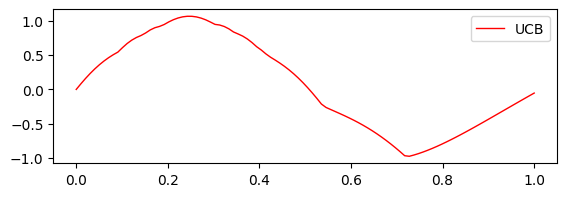

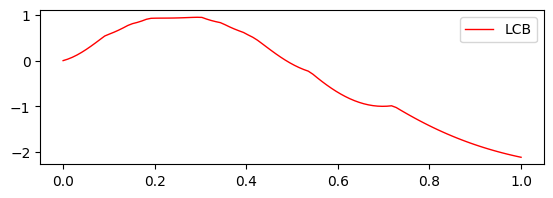

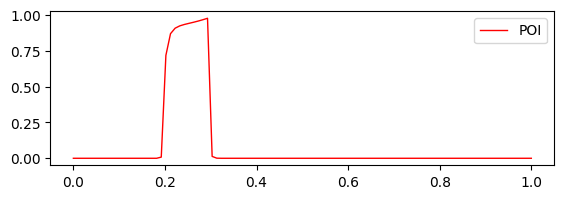

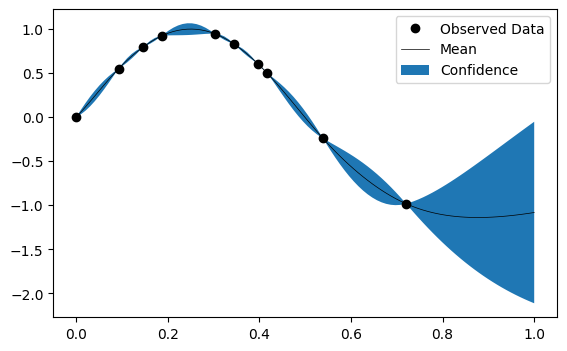

In [15]:
# Other plots
plot_acq(train_x, train_y,best_y=best_y,GPR = sampleGPR,acq_fun=ucb,acq_fun_name="UCB")
plot_acq(train_x, train_y,best_y=best_y,GPR = sampleGPR,acq_fun=lcb,acq_fun_name="LCB")
plot_acq(train_x, train_y,best_y=best_y,GPR = sampleGPR,acq_fun=poi,acq_fun_name="POI")
plot_prediction(train_x, train_y, gpr= sampleGPR)

### Final Remarks and Thought Exercises
1. Try changing the parameter `psi` in the case of all the Acquisition functions (all but Expected Improvement). Notice how this parameter controls the Exploration/Exploitation balance in each of the cases.
2. Try changing the Kernel used for Exercise 5 (check the mentioned reference from `scikit-learn` library). Investigate how the shape of the acquisition functions change (in this case keep the values of `psi` constant). 
3. **What's your opinion???** Do you think the modularity of the Bayesian Optimization Pipeline is an advantage or disadvantage of the method?